# Equity and Fixed Income Homework: P/E Investment Strategy DAX

Author: Adam Foster

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
from dateutil.relativedelta import relativedelta

# US CAPE-Returns

### Data Processing

In [2]:
raw = pd.read_csv('data_raw.csv', index_col=False, usecols=['Date','P','CAPE'], skiprows=7)

raw.tail()

,Date,P,CAPE
2451,NaN,NaN,NaN
2452,NaN,NaN,NaN
2453,NaN,NaN,NaN
2454,NaN,NaN,NaN
2455,NaN,NaN,NaN


In [3]:
data = raw.loc[raw['Date'] < 2016].copy()
data.tail()

,Date,P,CAPE
1735,2015.08,2039.87,25.69
1736,2015.09,1944.41,24.50
1737,2015.10,2024.81,25.49
1738,2015.11,2080.62,26.23
1739,2015.12,2054.08,25.97


In [4]:
date_list = raw['Date'].tolist()
shorter_dates = [i for i in date_list if len(str(i)) == 6]
shorter_dates

[1871.1,
 1872.1,
 1873.1,
 1874.1,
 1875.1,
 1876.1,
 1877.1,
 1878.1,
 1879.1,
 1880.1,
 1881.1,
 1882.1,
 1883.1,
 1884.1,
 1885.1,
 1886.1,
 1887.1,
 1888.1,
 1889.1,
 1890.1,
 1891.1,
 1892.1,
 1893.1,
 1894.1,
 1895.1,
 1896.1,
 1897.1,
 1898.1,
 1899.1,
 1900.1,
 1901.1,
 1902.1,
 1903.1,
 1904.1,
 1905.1,
 1906.1,
 1907.1,
 1908.1,
 1909.1,
 1910.1,
 1911.1,
 1912.1,
 1913.1,
 1914.1,
 1915.1,
 1916.1,
 1917.1,
 1918.1,
 1919.1,
 1920.1,
 1921.1,
 1922.1,
 1923.1,
 1924.1,
 1925.1,
 1926.1,
 1927.1,
 1928.1,
 1929.1,
 1930.1,
 1931.1,
 1932.1,
 1933.1,
 1934.1,
 1935.1,
 1936.1,
 1937.1,
 1938.1,
 1939.1,
 1940.1,
 1941.1,
 1942.1,
 1943.1,
 1944.1,
 1945.1,
 1946.1,
 1947.1,
 1948.1,
 1949.1,
 1950.1,
 1951.1,
 1952.1,
 1953.1,
 1954.1,
 1955.1,
 1956.1,
 1957.1,
 1958.1,
 1959.1,
 1960.1,
 1961.1,
 1962.1,
 1963.1,
 1964.1,
 1965.1,
 1966.1,
 1967.1,
 1968.1,
 1969.1,
 1970.1,
 1971.1,
 1972.1,
 1973.1,
 1974.1,
 1975.1,
 1976.1,
 1977.1,
 1978.1,
 1979.1,
 1980.1,
 1981.1,
 

In [5]:
data['DateFixed'] = data.apply(lambda x: str(x['Date'])[:4] + '.0' + str(x['Date'])[-1:] if len(str(x['Date'])) == 6 else x['Date'], axis=1)
data.head()

,Date,P,CAPE,DateFixed
0,1871.01,4.44,NaN,1871.01
1,1871.02,4.50,NaN,1871.02
2,1871.03,4.61,NaN,1871.03
3,1871.04,4.74,NaN,1871.04
4,1871.05,4.86,NaN,1871.05


In [6]:
date_list_new = data['DateFixed'].tolist()
shorter_dates_new = [i for i in date_list_new if len(str(i)) == 6]
shorter_dates_new

[]

In [7]:
data['DateMonth'] = data.apply(lambda x: datetime.datetime.strptime(str(x['DateFixed']), '%Y.%m'), axis = 1).dt.date

In [8]:
data['Price'] = data.apply(lambda x: float(x['P']), axis=1)

In [9]:
data = data.drop(['Date','DateFixed','P'], axis=1)

### Returns per CAPE Buckets

In [10]:
data_enhanced = data
data_enhanced['Return_10y'] = data_enhanced['Price'].pct_change(120)
data_enhanced['Return_1y'] = data_enhanced['Price'].pct_change(12)
data_enhanced['Return_3m'] = data_enhanced['Price'].pct_change(3)
data_enhanced['Return_1m'] = data_enhanced['Price'].pct_change(1)
data_enhanced['Return_10y_Ann'] = ((data_enhanced['Return_10y'] + 1) ** 0.1) - 1
data_enhanced['Return_1y_Ann'] = data_enhanced['Return_1y']
data_enhanced['Return_3m_Ann'] = ((data_enhanced['Return_3m'] + 1) ** 4) - 1
data_enhanced['Return_1m_Ann'] = ((data_enhanced['Return_1m'] + 1) ** 12) - 1

In [11]:
data_bounded = data_enhanced.loc[data_enhanced['DateMonth'] >= datetime.date(1900, 1, 1)].copy()

In [12]:
quantiles_full = round(data_bounded[['CAPE']].quantile([0.2, 0.4, 0.6, 0.8]), 1)
quantiles_full

,CAPE
0.2,10.6
0.4,13.6
0.6,17.7
0.8,21.8


In [13]:
def quantiles_condition(x):
    if x['CAPE'] > quantiles_full['CAPE'][0.8]:
        return 'a)Above' + str(quantiles_full['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full['CAPE'][0.6]:
        return 'b)' + str(quantiles_full['CAPE'][0.6]) + 'to' + str(quantiles_full['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full['CAPE'][0.4]:
        return 'c)' + str(quantiles_full['CAPE'][0.4]) + 'to' + str(quantiles_full['CAPE'][0.6])
    elif x['CAPE'] > quantiles_full['CAPE'][0.2]:
        return 'd)' + str(quantiles_full['CAPE'][0.2]) + 'to' + str(quantiles_full['CAPE'][0.4])
    elif x['CAPE'] > 0:
        return 'e)' + 'Below' + str(quantiles_full['CAPE'][0.2])
    else:
        return 'NA'

In [14]:
data_enhanced['CAPE_Bucket_Full'] = data_enhanced.apply(lambda x: quantiles_condition(x), axis=1)

In [15]:
data_enhanced['CAPE_Bucket_Full_Lagged_10y'] = data_enhanced[['CAPE_Bucket_Full']].shift(120)

In [16]:
data_enhanced['Perc_0.2_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.2)
data_enhanced['Perc_0.4_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.4)
data_enhanced['Perc_0.6_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.6)
data_enhanced['Perc_0.8_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.8)

In [17]:
def quantiles_roll_condition(x):
    if x['CAPE'] > x['Perc_0.8_Roll']:
        return 1
    elif x['CAPE'] > x['Perc_0.6_Roll']:
        return 2
    elif x['CAPE'] > x['Perc_0.4_Roll']:
        return 3
    elif x['CAPE'] > x['Perc_0.2_Roll']:
        return 4
    elif x['CAPE'] > 0:
        return 5
    else:
        return 0

In [18]:
data_enhanced['CAPE_Bucket_Roll'] = data_enhanced.apply(lambda x: quantiles_roll_condition(x), axis=1)

In [19]:
data_enhanced['CAPE_Bucket_Roll_Lagged_10y'] = data_enhanced[['CAPE_Bucket_Roll']].shift(120)
data_enhanced['CAPE_Bucket_Roll_Lagged_1y'] = data_enhanced[['CAPE_Bucket_Roll']].shift(12)
data_enhanced['CAPE_Bucket_Roll_Lagged_3m'] = data_enhanced[['CAPE_Bucket_Roll']].shift(3)
data_enhanced['CAPE_Bucket_Roll_Lagged_1m'] = data_enhanced[['CAPE_Bucket_Roll']].shift(1)

In [20]:
data_enhanced['EP'] = 1 / data_enhanced['CAPE']
data_enhanced['EP_Lagged_10y'] = data_enhanced['EP'].shift(120)
data_enhanced['EP_Lagged_1y'] = data_enhanced['EP'].shift(12)
data_enhanced['EP_Lagged_1m'] = data_enhanced['EP'].shift(1)

In [21]:
data_bounded = data_enhanced.loc[data_enhanced['DateMonth'] >= datetime.date(1900, 1, 1)].copy()

In [22]:
#data_bounded.to_csv('data_bounded.csv')

In [23]:
data_grouped_full = data_bounded.groupby('CAPE_Bucket_Full_Lagged_10y')['Return_10y_Ann'].mean()

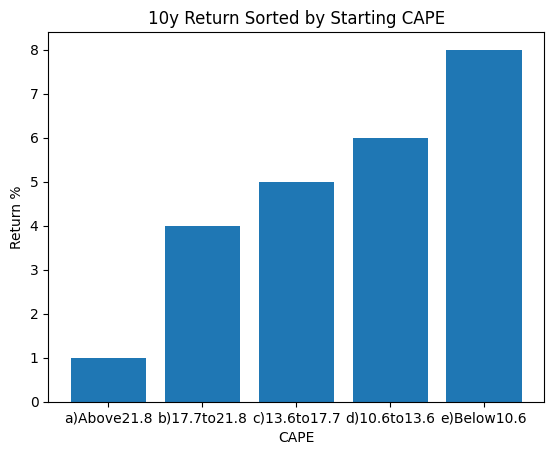

In [24]:
ret10y_fixed = [round(i * 100) for i in data_grouped_full.tolist()]
plt.bar(data_grouped_full.keys().tolist(), ret10y_fixed)
plt.title('10y Return Sorted by Starting CAPE')
plt.xlabel('CAPE')
plt.ylabel('Return %')
plt.show()

In [25]:
data_grouped_roll_10y = data_bounded.groupby('CAPE_Bucket_Roll_Lagged_10y')['Return_10y_Ann'].mean()
data_grouped_roll_1y = data_bounded.groupby('CAPE_Bucket_Roll_Lagged_1y')['Return_1y_Ann'].mean()
data_grouped_roll_3m = data_bounded.groupby('CAPE_Bucket_Roll_Lagged_3m')['Return_3m_Ann'].mean()
data_grouped_roll_1m = data_bounded.groupby('CAPE_Bucket_Roll_Lagged_1m')['Return_1m_Ann'].mean()

In [26]:
data_grouped_roll = pd.concat([data_grouped_roll_10y, data_grouped_roll_1y, data_grouped_roll_3m], axis=1)
data_grouped_roll

,Return_10y_Ann,Return_1y_Ann,Return_3m_Ann
1.0,0.026722,0.035296,0.079456
2.0,0.054985,0.048485,0.103214
3.0,0.074607,0.069423,0.120249
4.0,0.072331,0.114090,0.110780
5.0,0.056143,0.099980,0.169135


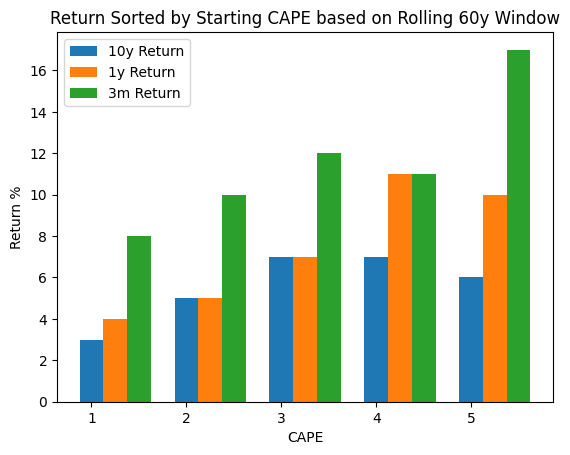

In [27]:
x = [1, 2, 3, 4, 5]
ret10y = data_grouped_roll['Return_10y_Ann'].tolist()
ret10y = [round(i * 100) for i in ret10y]
ret1y = data_grouped_roll['Return_1y_Ann'].tolist()
ret1y = [round(i * 100) for i in ret1y]
ret1m = data_grouped_roll['Return_3m_Ann'].tolist()
ret1m = [round(i * 100) for i in ret1m]

x_axis = np.arange(len(x))
width = 0.25

plt.bar(x_axis, ret10y, width = width, label = '10y Return')
plt.bar(x_axis + width, ret1y, width = width, label = '1y Return')
plt.bar(x_axis + width * 2, ret1m, width = width, label = '3m Return')

plt.xticks(x_axis, x)
plt.xlabel("CAPE")
plt.ylabel("Return %")
plt.title("Return Sorted by Starting CAPE based on Rolling 60y Window")
plt.legend()
plt.show()

### Regression

In [28]:
data_bounded

,CAPE,DateMonth,Price,Return_10y,Return_1y,Return_3m,Return_1m,Return_10y_Ann,Return_1y_Ann,Return_3m_Ann,...,Perc_0.8_Roll,CAPE_Bucket_Roll,CAPE_Bucket_Roll_Lagged_10y,CAPE_Bucket_Roll_Lagged_1y,CAPE_Bucket_Roll_Lagged_3m,CAPE_Bucket_Roll_Lagged_1m,EP,EP_Lagged_10y,EP_Lagged_1y,EP_Lagged_1m
348,18.67,1900-01-01,6.10,0.133829,0.003289,-0.037855,0.013289,0.012639,0.003289,-0.143037,...,18.204,1,2.0,1.0,1.0,1.0,0.053562,0.058072,0.043611,0.054025
349,18.70,1900-02-01,6.21,0.167293,-0.015848,-0.038700,0.018033,0.015589,-0.015848,-0.146042,...,18.222,1,2.0,1.0,1.0,1.0,0.053476,0.058720,0.043384,0.053562
350,18.78,1900-03-01,6.26,0.185606,-0.021875,0.039867,0.008052,0.017171,-0.021875,0.169261,...,18.270,1,2.0,1.0,1.0,1.0,0.053248,0.059172,0.042955,0.053476
351,18.94,1900-04-01,6.34,0.176252,-0.021605,0.039344,0.012780,0.016366,-0.021605,0.166911,...,18.342,1,1.0,1.0,1.0,1.0,0.052798,0.057937,0.043197,0.053248
352,18.40,1900-05-01,6.04,0.074733,-0.027375,-0.027375,-0.047319,0.007233,-0.027375,-0.105086,...,18.384,1,1.0,1.0,1.0,1.0,0.054348,0.056211,0.045269,0.052798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,25.69,2015-08-01,2039.87,0.666193,0.039938,-0.034125,-0.025915,0.052380,0.039938,-0.129671,...,24.872,1,1.0,1.0,1.0,1.0,0.038926,0.038314,0.039032,0.037908
1736,24.50,2015-09-01,1944.41,0.586082,-0.024493,-0.073777,-0.046797,0.047207,-0.024493,-0.264027,...,24.872,2,1.0,1.0,1.0,1.0,0.040816,0.038865,0.038580,0.038926
1737,25.49,2015-01-01,2024.81,0.698723,0.045187,-0.033107,0.041349,0.054417,0.045187,-0.125994,...,24.892,1,1.0,1.0,1.0,2.0,0.039231,0.040193,0.039746,0.040816
1738,26.23,2015-11-01,2080.62,0.681486,0.017632,0.019977,0.027563,0.053342,0.017632,0.082334,...,24.944,1,1.0,1.0,1.0,1.0,0.038124,0.038565,0.037580,0.039231


In [29]:
#data_bounded.to_csv('data_bounded.csv')

In [30]:
x_10y = np.array(data_bounded['EP_Lagged_10y'])
x_1y = np.array(data_bounded['EP_Lagged_1y'])
x_1m = np.array(data_bounded['EP_Lagged_1m'])
y_10y = np.array(data_bounded['Return_10y_Ann'])
y_1y = np.array(data_bounded['Return_1y_Ann'])
y_1m = np.array(data_bounded['Return_1m_Ann'])

reg_10y_mod = sm.OLS(y_10y, x_10y)
reg_10y = reg_10y_mod.fit()
print(reg_10y.summary())

reg_1y_mod = sm.OLS(y_1y, x_1y)
reg_1y = reg_1y_mod.fit()
print(reg_1y.summary())

reg_1m_mod = sm.OLS(y_1m, x_1m)
reg_1m = reg_1m_mod.fit()
print(reg_1m.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.571
Model:                            OLS   Adj. R-squared (uncentered):              0.571
Method:                 Least Squares   F-statistic:                              1850.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                   9.00e-258
Time:                        15:15:53   Log-Likelihood:                          2267.9
No. Observations:                1392   AIC:                                     -4534.
Df Residuals:                    1391   BIC:                                     -4529.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [31]:
reg_stats_raw = []
for reg in [reg_10y, reg_1y, reg_1m]:
    reg_stats_i = [round(reg.params[0],2), round(reg.tvalues[0],2), round(reg.rsquared,2)]
    reg_stats_i = pd.Series(reg_stats_i)
    reg_stats_raw.append(reg_stats_i)

reg_stats = pd.concat(reg_stats_raw, axis=1)
reg_stats.columns = ['Next 10Y', 'Next 1Y', 'Next 1M']
reg_stats['Stat'] = ['Beta', 'T-statistic', 'R-squared']
reg_stats = reg_stats.iloc[:,[3, 0, 1, 2]]

In [32]:
reg_stats

,Stat,Next 10Y,Next 1Y,Next 1M
0,Beta,0.69,1.00,4.79
1,T-statistic,43.01,15.42,3.92
2,R-squared,0.57,0.15,0.01


# Germany CAPE-Returns

### Data Processing

In [33]:
raw_dax = yf.download("^GDAXI", start='1988-02-01', end='2023-05-31', interval='1mo')
raw_dax

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1988-02-01,951.500000,1091.589966,951.500000,1083.339966,1083.339966,0
1988-03-01,1087.319946,1123.270020,1037.260010,1062.329956,1062.329956,0
1988-04-01,1063.280029,1102.329956,1049.170044,1049.170044,1049.170044,0
1988-05-01,1052.839966,1075.660034,994.349976,1075.660034,1075.660034,0
1988-06-01,1095.430054,1138.839966,1095.430054,1133.810059,1133.810059,0
...,...,...,...,...,...,...
2023-01-01,13992.709961,15269.709961,13976.440430,15128.269531,15128.269531,1263845700
2023-02-01,15125.120117,15658.559570,15107.830078,15365.139648,15365.139648,1321833900
2023-03-01,15399.910156,15706.370117,14458.389648,15628.839844,15628.839844,2329276000


In [34]:
raw_german_cape = pd.read_csv('Historic-cape-ratios.csv', index_col=False)
raw_german_cape

,Date,Germany
0,29/01/1982,9.76
1,26/02/1982,9.85
2,31/03/1982,10.13
3,30/04/1982,10.12
4,31/05/1982,9.55
...,...,...
492,31/01/2023,18.92
493,28/02/2023,18.94
494,31/03/2023,19.68
495,28/04/2023,20.03


In [35]:
def month_end(test_date):
    nxt_mnth = test_date.replace(day=28) + datetime.timedelta(days=4)
    res = nxt_mnth - datetime.timedelta(days=nxt_mnth.day)
    return res

In [36]:
data_german_cape = raw_german_cape
data_german_cape['DateFormat'] = data_german_cape.apply(lambda x: datetime.datetime.strptime(x['Date'], '%d/%m/%Y'), axis = 1).dt.date
data_german_cape['DateFormatEnd'] = data_german_cape.apply(lambda x: month_end(x['DateFormat']), axis=1)
data_german_cape = data_german_cape.drop(['Date','DateFormat'], axis=1)

In [37]:
data_dax = raw_dax
data_dax = data_dax[['Close']]
data_dax = data_dax.reset_index()
data_dax['DateFormat'] = data_dax['Date'].dt.date
data_dax['DateFormatShift'] = data_dax.apply(lambda x: x['Date'] - relativedelta(months=1), axis=1)
data_dax['DateFormatShiftEnd'] = data_dax.apply(lambda x: month_end(x['DateFormatShift']), axis=1)
data_dax['DateReformat'] = data_dax['DateFormatShiftEnd'].dt.date
data_dax = data_dax.drop(['Date', 'DateFormat', 'DateFormatShift', 'DateFormatShiftEnd'], axis=1)

In [38]:
data_germany = data_german_cape.merge(data_dax, how='left', left_on='DateFormatEnd', right_on='DateReformat')
data_germany = data_germany.drop(['DateReformat'], axis=1)
data_germany = data_germany.rename(columns={'Germany': 'CAPE', 'DateFormatEnd': 'Date', 'Close': 'Price'})

In [39]:
data_germany

,CAPE,Date,Price
0,9.76,1982-01-31,NaN
1,9.85,1982-02-28,NaN
2,10.13,1982-03-31,NaN
3,10.12,1982-04-30,NaN
4,9.55,1982-05-31,NaN
...,...,...,...
492,18.92,2023-01-31,15365.139648
493,18.94,2023-02-28,15628.839844
494,19.68,2023-03-31,15922.379883
495,20.03,2023-04-30,15664.019531


In [40]:
#data_germany.to_csv('data_germany.csv')

### Returns per CAPE Buckets

In [41]:
data_enhanced_ger = data_germany
data_enhanced_ger['Return_10y'] = data_enhanced_ger['Price'].pct_change(120)
data_enhanced_ger['Return_5y'] = data_enhanced_ger['Price'].pct_change(60)
data_enhanced_ger['Return_1y'] = data_enhanced_ger['Price'].pct_change(12)
data_enhanced_ger['Return_3m'] = data_enhanced_ger['Price'].pct_change(3)
data_enhanced_ger['Return_1m'] = data_enhanced_ger['Price'].pct_change(1)
data_enhanced_ger['Return_10y_Ann'] = ((data_enhanced_ger['Return_10y'] + 1) ** 0.1) - 1
data_enhanced_ger['Return_5y_Ann'] = ((data_enhanced_ger['Return_5y'] + 1) ** 0.2) - 1
data_enhanced_ger['Return_1y_Ann'] = data_enhanced_ger['Return_1y']
data_enhanced_ger['Return_3m_Ann'] = ((data_enhanced_ger['Return_3m'] + 1) ** 4) - 1
data_enhanced_ger['Return_1m_Ann'] = ((data_enhanced_ger['Return_1m'] + 1) ** 12) - 1

In [42]:
data_bounded_ger = data_enhanced_ger.loc[(data_enhanced_ger['Date'] >= datetime.date(1993, 1, 1)) & (data_enhanced_ger['Date'] <= datetime.date(2023, 4, 30))].copy() # later start than S&P

In [43]:
quantiles_full_ger = round(data_bounded_ger[['CAPE']].quantile([0.2, 0.4, 0.6, 0.8]), 1)
quantiles_full_ger

,CAPE
0.2,18.8
0.4,20.4
0.6,22.7
0.8,29.5


In [44]:
def quantiles_condition_ger(x):
    if x['CAPE'] > quantiles_full_ger['CAPE'][0.8]:
        return 'a)Above' + str(quantiles_full_ger['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full_ger['CAPE'][0.6]:
        return 'b)' + str(quantiles_full_ger['CAPE'][0.6]) + 'to' + str(quantiles_full_ger['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full_ger['CAPE'][0.4]:
        return 'c)' + str(quantiles_full_ger['CAPE'][0.4]) + 'to' + str(quantiles_full_ger['CAPE'][0.6])
    elif x['CAPE'] > quantiles_full_ger['CAPE'][0.2]:
        return 'd)' + str(quantiles_full_ger['CAPE'][0.2]) + 'to' + str(quantiles_full_ger['CAPE'][0.4])
    elif x['CAPE'] > 0:
        return 'e)' + 'Below' + str(quantiles_full_ger['CAPE'][0.2])
    else:
        return 'NA'

In [45]:
data_enhanced_ger['CAPE_Bucket_Full'] = data_enhanced_ger.apply(lambda x: quantiles_condition_ger(x), axis=1)

In [46]:
data_enhanced_ger['CAPE_Bucket_Full_Lagged_5y'] = data_enhanced_ger[['CAPE_Bucket_Full']].shift(60) #shorter lag at 5yrs

In [47]:
data_enhanced_ger['Perc_0.2_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.2) # shorter roll window 20yrs
data_enhanced_ger['Perc_0.4_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.4)
data_enhanced_ger['Perc_0.6_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.6)
data_enhanced_ger['Perc_0.8_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.8)

In [48]:
data_enhanced_ger['CAPE_Bucket_Roll'] = data_enhanced_ger.apply(lambda x: quantiles_roll_condition(x), axis=1)

In [49]:
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_10y'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(120) # shorter roll window 20yrs
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_5y'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(60) # shorter roll window 20yrs
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_1y'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(12)
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_3m'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(3)
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_1m'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(1)

In [50]:
data_enhanced_ger['EP'] = 1 / data_enhanced_ger['CAPE']
data_enhanced_ger['EP_Lagged_5y'] = data_enhanced_ger['EP'].shift(60)
data_enhanced_ger['EP_Lagged_1y'] = data_enhanced_ger['EP'].shift(12)
data_enhanced_ger['EP_Lagged_1m'] = data_enhanced_ger['EP'].shift(1)

In [51]:
data_bounded_ger = data_enhanced_ger.loc[(data_enhanced_ger['Date'] >= datetime.date(1993, 1, 1)) & (data_enhanced_ger['Date'] <= datetime.date(2023, 4, 30))].copy() # later start than S&P

In [52]:
#data_bounded_ger.to_csv('data_bounded_ger.csv')

In [53]:
data_grouped_full_ger = data_bounded_ger.groupby('CAPE_Bucket_Full_Lagged_5y')['Return_5y_Ann'].mean() # reduced to 5yrs

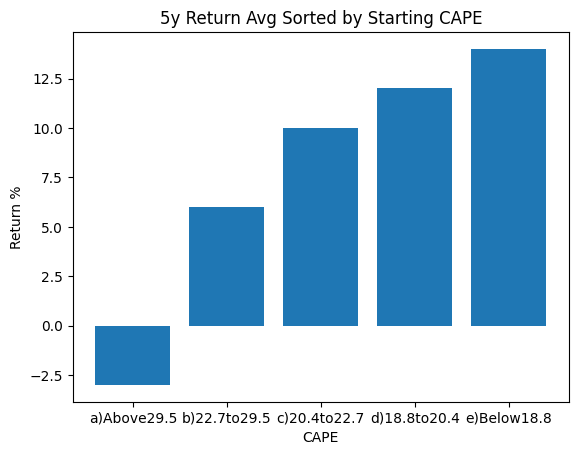

In [54]:
ret5y_fixed = [round(i * 100) for i in data_grouped_full_ger.tolist()]
plt.bar(data_grouped_full_ger.keys().tolist(), ret5y_fixed)
plt.title('5y Return Avg Sorted by Starting CAPE')
plt.xlabel('CAPE')
plt.ylabel('Return %')
plt.show()

In [55]:
data_grouped_roll_10y_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_10y')['Return_10y_Ann'].mean()
data_grouped_roll_5y_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_5y')['Return_5y_Ann'].mean()
data_grouped_roll_1y_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_1y')['Return_1y_Ann'].mean()
data_grouped_roll_3m_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_3m')['Return_3m_Ann'].mean()
data_grouped_roll_1m_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_1m')['Return_1m_Ann'].mean()

In [56]:
data_grouped_roll_ger = pd.concat([data_grouped_roll_5y_ger, data_grouped_roll_1y_ger, data_grouped_roll_1m_ger], axis=1)
data_grouped_roll_ger

,Return_5y_Ann,Return_1y_Ann,Return_1m_Ann
1.0,0.016716,0.153267,0.468558
2.0,0.088456,0.004493,0.281207
3.0,0.091423,0.034382,0.103803
4.0,0.098388,0.122403,0.351031
5.0,0.117869,0.217113,0.580733


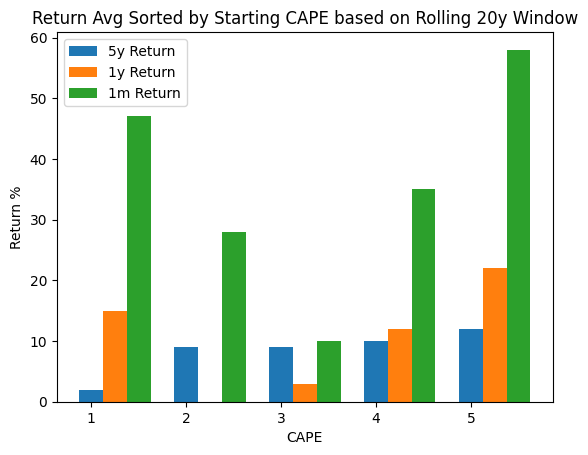

In [57]:
x = [1, 2, 3, 4, 5]
ret5y = data_grouped_roll_ger['Return_5y_Ann'].tolist() # shorter
ret5y = [round(i * 100) for i in ret5y]
ret1y = data_grouped_roll_ger['Return_1y_Ann'].tolist()
ret1y = [round(i * 100) for i in ret1y]
ret1m = data_grouped_roll_ger['Return_1m_Ann'].tolist()
ret1m = [round(i * 100) for i in ret1m]

x_axis = np.arange(len(x))
width = 0.25

plt.bar(x_axis, ret5y, width = width, label = '5y Return')
plt.bar(x_axis + width, ret1y, width = width, label = '1y Return')
plt.bar(x_axis + width * 2, ret1m, width = width, label = '1m Return')

plt.xticks(x_axis, x)
plt.xlabel("CAPE")
plt.ylabel("Return %")
plt.title("Return Avg Sorted by Starting CAPE based on Rolling 20y Window")
plt.legend()
plt.show()

### Regression

In [58]:
data_bounded_ger

,CAPE,Date,Price,Return_10y,Return_5y,Return_1y,Return_3m,Return_1m,Return_10y_Ann,Return_5y_Ann,...,CAPE_Bucket_Roll,CAPE_Bucket_Roll_Lagged_10y,CAPE_Bucket_Roll_Lagged_5y,CAPE_Bucket_Roll_Lagged_1y,CAPE_Bucket_Roll_Lagged_3m,CAPE_Bucket_Roll_Lagged_1m,EP,EP_Lagged_5y,EP_Lagged_1y,EP_Lagged_1m
132,15.86,1993-01-31,1680.020020,NaN,0.550778,-0.038208,0.087307,0.067330,NaN,0.091717,...,4,1.0,4.0,2.0,4.0,4.0,0.063052,0.075930,0.053505,0.064392
133,17.03,1993-02-28,1676.839966,NaN,0.578455,-0.024157,0.089968,-0.001893,NaN,0.095586,...,3,1.0,3.0,2.0,4.0,4.0,0.058720,0.064725,0.051361,0.063052
134,16.90,1993-03-31,1626.829956,NaN,0.550588,-0.058596,0.033538,-0.029824,NaN,0.091690,...,3,1.0,3.0,2.0,4.0,3.0,0.059172,0.067295,0.053390,0.058720
135,16.85,1993-04-30,1627.209961,NaN,0.512755,-0.099177,-0.031434,0.000234,NaN,0.086310,...,3,1.0,3.0,2.0,4.0,3.0,0.059347,0.067295,0.053277,0.059172
136,16.24,1993-05-31,1700.930054,NaN,0.500190,-0.030781,0.014366,0.045305,NaN,0.084499,...,4,1.0,3.0,2.0,3.0,3.0,0.061576,0.067659,0.052994,0.059347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,17.22,2022-12-31,15128.269531,0.945495,0.146995,-0.022166,0.141434,0.086521,0.068816,0.027809,...,5,5.0,3.0,3.0,5.0,4.0,0.058072,0.044092,0.045809,0.054113
492,18.92,2023-01-31,15365.139648,0.984724,0.235552,0.062521,0.067243,0.015657,0.070952,0.043211,...,4,5.0,3.0,3.0,5.0,5.0,0.052854,0.042808,0.047081,0.058072
493,18.94,2023-02-28,15628.839844,1.004903,0.291989,0.084226,0.122472,0.017162,0.072036,0.052572,...,4,5.0,3.0,4.0,4.0,4.0,0.052798,0.045809,0.050556,0.052854
494,19.68,2023-03-31,15922.379883,1.011999,0.262468,0.129417,0.052492,0.018782,0.072415,0.047717,...,4,5.0,3.0,4.0,5.0,4.0,0.050813,0.045475,0.050916,0.052798


In [59]:
#data_bounded_ger.to_csv('data_bounded_ger.csv')

In [60]:
x_5y = np.array(data_bounded_ger['EP_Lagged_5y'])
x_1y = np.array(data_bounded_ger['EP_Lagged_1y'])
x_1m = np.array(data_bounded_ger['EP_Lagged_1m'])
y_5y = np.array(data_bounded_ger['Return_5y_Ann'])
y_1y = np.array(data_bounded_ger['Return_1y_Ann'])
y_1m = np.array(data_bounded_ger['Return_1m_Ann'])

reg_5y_mod = sm.OLS(y_5y, x_5y)
reg_5y = reg_5y_mod.fit()
print(reg_5y.summary())

reg_1y_mod = sm.OLS(y_1y, x_1y)
reg_1y = reg_1y_mod.fit()
print(reg_1y.summary())

reg_1m_mod = sm.OLS(y_1m, x_1m)
reg_1m = reg_1m_mod.fit()
print(reg_1m.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.600
Model:                            OLS   Adj. R-squared (uncentered):              0.599
Method:                 Least Squares   F-statistic:                              543.8
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                    3.68e-74
Time:                        15:15:54   Log-Likelihood:                          425.94
No. Observations:                 364   AIC:                                     -849.9
Df Residuals:                     363   BIC:                                     -846.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [61]:
reg_stats_raw = []
for reg in [reg_5y, reg_1y, reg_1m]:
    reg_stats_i = [round(reg.params[0],2), round(reg.tvalues[0],2), round(reg.rsquared,2)]
    reg_stats_i = pd.Series(reg_stats_i)
    reg_stats_raw.append(reg_stats_i)

reg_stats = pd.concat(reg_stats_raw, axis=1)
reg_stats.columns = ['Next 5Y', 'Next 1Y', 'Next 1M']
reg_stats['Stat'] = ['Beta', 'T-statistic', 'R-squared']
reg_stats = reg_stats.iloc[:,[3, 0, 1, 2]]

In [62]:
reg_stats

,Stat,Next 5Y,Next 1Y,Next 1M
0,Beta,1.98,2.44,7.94
1,T-statistic,23.32,9.91,6.80
2,R-squared,0.60,0.21,0.11


### Investment Strategy

In [63]:
data_enhanced_ger_inv = data_enhanced_ger
data_enhanced_ger_inv['Roll_Median'] = data_enhanced_ger_inv[['EP']].rolling(240, min_periods=1).quantile(0.5) # 20y rolling window
data_enhanced_ger_inv['Roll_Perc_0.05'] = data_enhanced_ger_inv[['EP']].rolling(240, min_periods=1).quantile(0.05)
data_enhanced_ger_inv['Roll_Perc_0.95'] = data_enhanced_ger_inv[['EP']].rolling(240, min_periods=1).quantile(0.95)

In [64]:
libor = pd.read_csv('libor_input_filled.csv', index_col=False)
libor['DateFormat'] = libor.apply(lambda x: datetime.datetime.strptime(str(x['Date']), '%d/%m/%Y'), axis = 1).dt.date
libor['USD_1M_Libor'] = libor['Value'] / 100
libor = libor.drop(['Date', 'Value'], axis=1)
libor = libor.rename(columns={'DateFormat': 'Date'})
libor

,Date,USD_1M_Libor
0,1986-01-01,0.08060
1,1986-01-02,0.08125
2,1986-01-03,0.08125
3,1986-01-04,0.08125
4,1986-01-05,0.08125
...,...,...
13662,2023-05-29,0.05150
13663,2023-05-30,0.05170
13664,2023-05-31,0.05190
13665,2023-06-01,0.05160


In [65]:
data_enhanced_ger_inv = data_enhanced_ger_inv.merge(libor, how='left', on='Date')
data_enhanced_ger_inv

,CAPE,Date,Price,Return_10y,Return_5y,Return_1y,Return_3m,Return_1m,Return_10y_Ann,Return_5y_Ann,...,CAPE_Bucket_Roll_Lagged_3m,CAPE_Bucket_Roll_Lagged_1m,EP,EP_Lagged_5y,EP_Lagged_1y,EP_Lagged_1m,Roll_Median,Roll_Perc_0.05,Roll_Perc_0.95,USD_1M_Libor
0,9.76,1982-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.102459,NaN,NaN,NaN,0.102459,0.102459,0.102459,NaN
1,9.85,1982-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,0.101523,NaN,NaN,0.102459,0.101991,0.101570,0.102412,NaN
2,10.13,1982-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,0.098717,NaN,NaN,0.101523,0.101523,0.098997,0.102365,NaN
3,10.12,1982-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,0.098814,NaN,NaN,0.098717,0.100169,0.098731,0.102319,NaN
4,9.55,1982-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,0.104712,NaN,NaN,0.098814,0.101523,0.098736,0.104261,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,18.92,2023-01-31,15365.139648,0.984724,0.235552,0.062521,0.067243,0.015657,0.070952,0.043211,...,5.0,5.0,0.052854,0.042808,0.047081,0.058072,0.048936,0.034157,0.061047,0.0457
493,18.94,2023-02-28,15628.839844,1.004903,0.291989,0.084226,0.122472,0.017162,0.072036,0.052572,...,4.0,4.0,0.052798,0.045809,0.050556,0.052854,0.048936,0.034157,0.061047,0.0467
494,19.68,2023-03-31,15922.379883,1.011999,0.262468,0.129417,0.052492,0.018782,0.072415,0.047717,...,5.0,4.0,0.050813,0.045475,0.050916,0.052798,0.048936,0.034157,0.060837,0.0486
495,20.03,2023-04-30,15664.019531,0.876191,0.242694,0.088660,0.019452,-0.016226,0.064946,0.044414,...,4.0,4.0,0.049925,0.044209,0.053677,0.050813,0.048936,0.034157,0.060837,0.0506


In [66]:
#data_enhanced_ger_inv.to_csv('data_enhanced_ger_inv.csv')

In [67]:
data_bounded_ger_inv = data_enhanced_ger_inv.loc[(data_enhanced_ger_inv['Date'] >= datetime.date(1993, 1, 1)) & (data_enhanced_ger_inv['Date'] <= datetime.date(2023, 4, 30))].copy()

In [68]:
data_bounded_ger_inv['Equity_Weight_150_Init'] = data_bounded_ger_inv.apply(lambda x: min(1.5, max(0.5, 1 + (x['EP'] - x['Roll_Median']) / (x['Roll_Perc_0.95'] - x['Roll_Perc_0.05']))), axis=1)
data_bounded_ger_inv['Equity_Weight_150'] = data_bounded_ger_inv[['Equity_Weight_150_Init']].shift(1).fillna(1) # last period's EP-based decision
data_bounded_ger_inv['Cash_Weight_150'] = 1 - data_bounded_ger_inv['Equity_Weight_150']
data_bounded_ger_inv['Portfolio_150'] = data_bounded_ger_inv['Equity_Weight_150'] * data_bounded_ger_inv['Return_1m'] + data_bounded_ger_inv['Cash_Weight_150'] * data_bounded_ger_inv['USD_1M_Libor']

data_bounded_ger_inv['Equity_Weight_125_Init'] = data_bounded_ger_inv.apply(lambda x: min(1.25, max(0.75, 1 + (x['EP'] - x['Roll_Median']) / (x['Roll_Perc_0.95'] - x['Roll_Perc_0.05']))), axis=1)
data_bounded_ger_inv['Equity_Weight_125'] = data_bounded_ger_inv[['Equity_Weight_125_Init']].shift(1).fillna(1) # last period's EP-based decision
data_bounded_ger_inv['Cash_Weight_125'] = 1 - data_bounded_ger_inv['Equity_Weight_125']
data_bounded_ger_inv['Portfolio_125'] = data_bounded_ger_inv['Equity_Weight_125'] * data_bounded_ger_inv['Return_1m'] + data_bounded_ger_inv['Cash_Weight_125'] * data_bounded_ger_inv['USD_1M_Libor']

In [69]:
data_bounded_ger_inv

,CAPE,Date,Price,Return_10y,Return_5y,Return_1y,Return_3m,Return_1m,Return_10y_Ann,Return_5y_Ann,...,Roll_Perc_0.95,USD_1M_Libor,Equity_Weight_150_Init,Equity_Weight_150,Cash_Weight_150,Portfolio_150,Equity_Weight_125_Init,Equity_Weight_125,Cash_Weight_125,Portfolio_125
132,15.86,1993-01-31,1680.020020,NaN,0.550778,-0.038208,0.087307,0.067330,NaN,0.091717,...,0.102083,0.0313,1.109655,1.000000,0.000000,0.067330,1.109655,1.000000,0.000000,0.067330
133,17.03,1993-02-28,1676.839966,NaN,0.578455,-0.024157,0.089968,-0.001893,NaN,0.095586,...,0.102052,0.0319,1.038492,1.109655,-0.109655,-0.005598,1.038492,1.109655,-0.109655,-0.005598
134,16.90,1993-03-31,1626.829956,NaN,0.550588,-0.058596,0.033538,-0.029824,NaN,0.091690,...,0.102021,0.0319,1.045100,1.038492,-0.038492,-0.032200,1.045100,1.038492,-0.038492,-0.032200
135,16.85,1993-04-30,1627.209961,NaN,0.512755,-0.099177,-0.031434,0.000234,NaN,0.086310,...,0.101989,0.0313,1.047477,1.045100,-0.045100,-0.001168,1.047477,1.045100,-0.045100,-0.001168
136,16.24,1993-05-31,1700.930054,NaN,0.500190,-0.030781,0.014366,0.045305,NaN,0.084499,...,0.101958,0.0325,1.083346,1.047477,-0.047477,0.045913,1.083346,1.047477,-0.047477,0.045913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,17.22,2022-12-31,15128.269531,0.945495,0.146995,-0.022166,0.141434,0.086521,0.068816,0.027809,...,0.061047,0.0439,1.339773,1.196516,-0.196516,0.094896,1.250000,1.196516,-0.196516,0.094896
492,18.92,2023-01-31,15365.139648,0.984724,0.235552,0.062521,0.067243,0.015657,0.070952,0.043211,...,0.061047,0.0457,1.145725,1.339773,-0.339773,0.005450,1.145725,1.250000,-0.250000,0.008147
493,18.94,2023-02-28,15628.839844,1.004903,0.291989,0.084226,0.122472,0.017162,0.072036,0.052572,...,0.061047,0.0467,1.143649,1.145725,-0.145725,0.012858,1.143649,1.145725,-0.145725,0.012858
494,19.68,2023-03-31,15922.379883,1.011999,0.262468,0.129417,0.052492,0.018782,0.072415,0.047717,...,0.060837,0.0486,1.070367,1.143649,-0.143649,0.014499,1.070367,1.143649,-0.143649,0.014499


In [70]:
# data_bounded_ger_inv.to_csv('data_bounded_ger_inv.csv')

In [71]:
date_range = data_bounded_ger_inv['Date'].tolist()

return_1m = data_bounded_ger_inv['Return_1m'].tolist()
return_scalar_1m = [i + 1 for i in return_1m]
return_1m_cum_i = 1
return_1m_cum = [(return_1m_cum_i:=return_1m_cum_i*v) for v in return_scalar_1m]
return_1m_cum = [i - 1 for i in return_1m_cum]

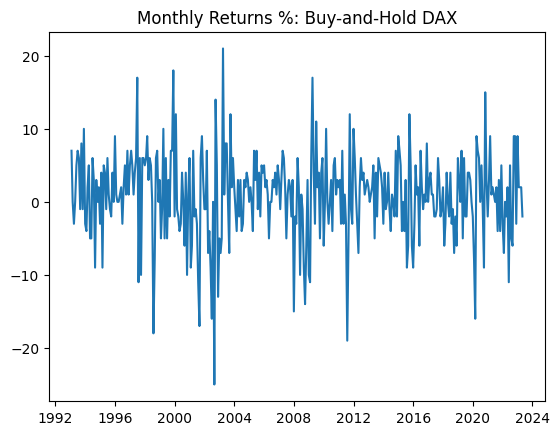

In [72]:
return_1m_perc = [round(i * 100) for i in return_1m]
plt.plot(date_range, return_1m_perc)
plt.title('Monthly Returns %: Buy-and-Hold DAX')
plt.show()

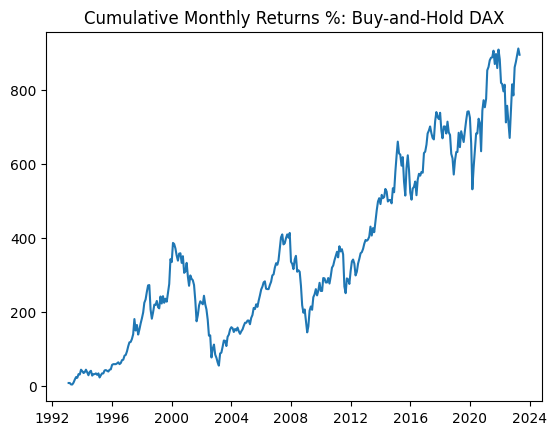

In [73]:
return_1m_cum_perc = [round(i * 100) for i in return_1m_cum]
plt.plot(date_range, return_1m_cum_perc)
plt.title('Cumulative Monthly Returns %: Buy-and-Hold DAX')
plt.show()

In [74]:
return_1m_pe150 = data_bounded_ger_inv['Portfolio_150'].tolist()
return_scalar_1m_pe150 = [i + 1 for i in return_1m_pe150]
return_1m_pe150_cum_i = 1
return_1m_pe150_cum = [(return_1m_pe150_cum_i:=return_1m_pe150_cum_i*v) for v in return_scalar_1m_pe150]
return_1m_pe150_cum = [i - 1 for i in return_1m_pe150_cum]

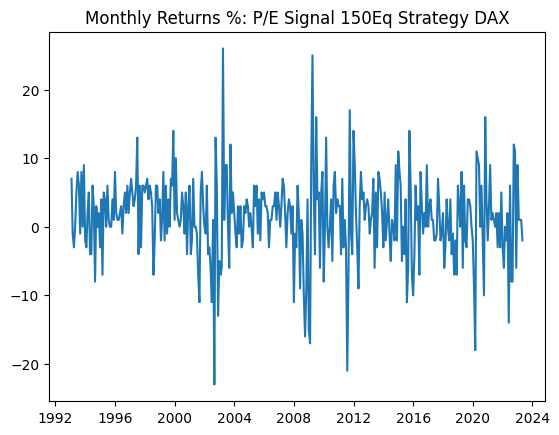

In [75]:
return_1m_pe150_perc = [round(i * 100) for i in return_1m_pe150]
plt.plot(date_range, return_1m_pe150_perc)
plt.title('Monthly Returns %: P/E Signal 150Eq Strategy DAX')
plt.show()

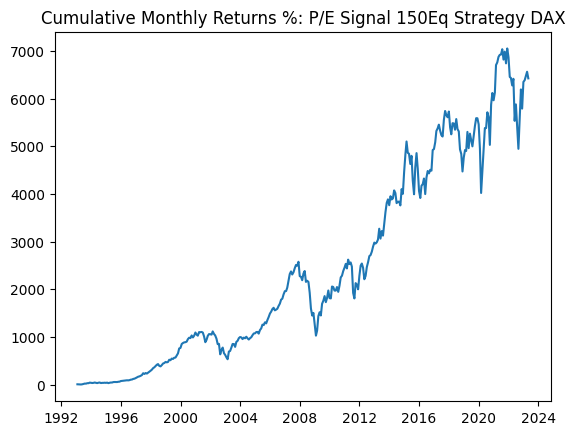

In [76]:
return_1m_pe150_cum_perc = [round(i * 100) for i in return_1m_pe150_cum]
plt.plot(date_range, return_1m_pe150_cum_perc)
plt.title('Cumulative Monthly Returns %: P/E Signal 150Eq Strategy DAX')
plt.show()

In [77]:
return_1m_pe125 = data_bounded_ger_inv['Portfolio_125'].tolist()
return_scalar_1m_pe125 = [i + 1 for i in return_1m_pe125]
return_1m_pe125_cum_i = 1
return_1m_pe125_cum = [(return_1m_pe125_cum_i:=return_1m_pe125_cum_i*v) for v in return_scalar_1m_pe125]
return_1m_pe125_cum = [i - 1 for i in return_1m_pe125_cum]

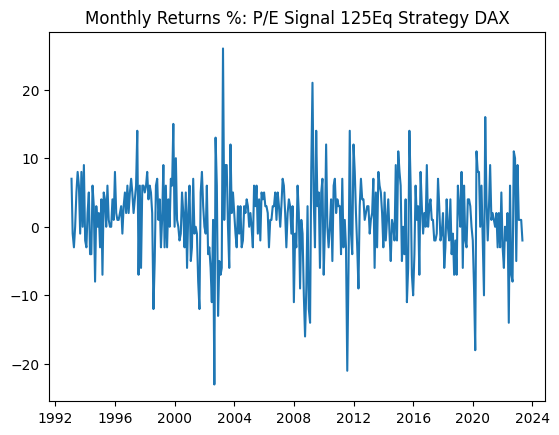

In [78]:
return_1m_pe125_perc = [round(i * 100) for i in return_1m_pe125]
plt.plot(date_range, return_1m_pe125_perc)
plt.title('Monthly Returns %: P/E Signal 125Eq Strategy DAX')
plt.show()

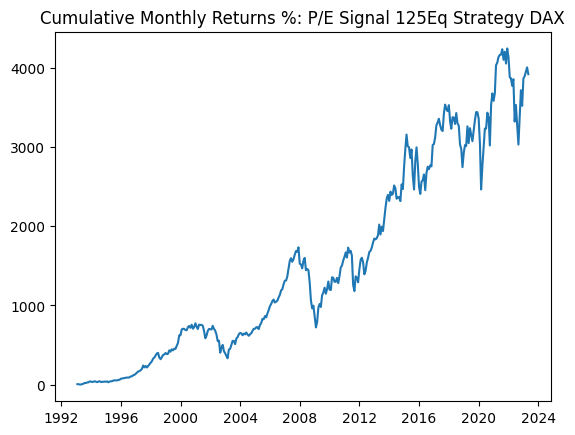

In [79]:
return_1m_pe125_cum_perc = [round(i * 100) for i in return_1m_pe125_cum]
plt.plot(date_range, return_1m_pe125_cum_perc)
plt.title('Cumulative Monthly Returns %: P/E Signal 125Eq Strategy DAX')
plt.show()

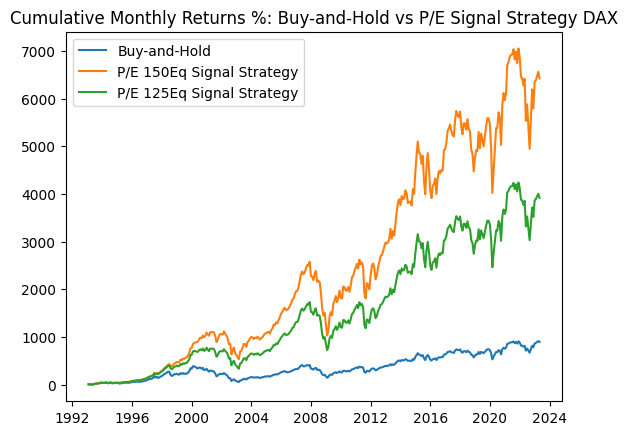

In [80]:
plt.plot(date_range, return_1m_cum_perc, label='Buy-and-Hold')
plt.plot(date_range, return_1m_pe150_cum_perc, label='P/E 150Eq Signal Strategy')
plt.plot(date_range, return_1m_pe125_cum_perc, label='P/E 125Eq Signal Strategy')
plt.title('Cumulative Monthly Returns %: Buy-and-Hold vs P/E Signal Strategy DAX')
plt.legend()
plt.show()

In [81]:
print(str(return_1m_cum_perc[-1]) + '%')
print(str(return_1m_pe150_cum_perc[-1]) + '%')
print(str(return_1m_pe125_cum_perc[-1]) + '%')

895%
6424%
3917%


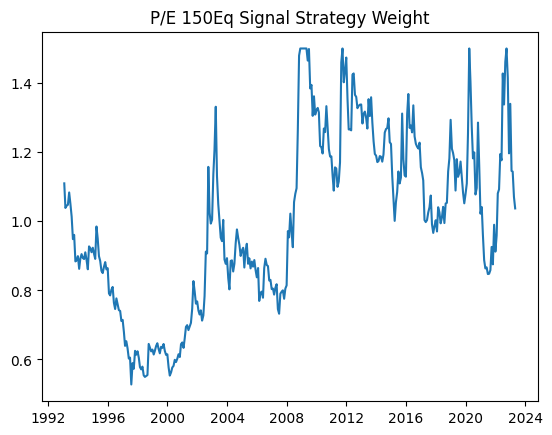

In [82]:
weight_eq150 = data_bounded_ger_inv['Equity_Weight_150_Init'].tolist()
plt.plot(date_range, weight_eq150, label='Equity Weight')
plt.title('P/E 150Eq Signal Strategy Weight')
plt.show()

In [83]:
portfolio_100_ann_mean = np.mean(data_bounded_ger_inv['Return_1m_Ann'].tolist())
portfolio_100_ann_std = np.std(data_bounded_ger_inv['Return_1m_Ann'].tolist())
portfolio_100_sharpe = portfolio_100_ann_mean / portfolio_100_ann_std
portfolio_100_avg_pos = 1

In [84]:
rolling_dd = []
for index, value in enumerate(return_1m_cum_perc):
    rolling_max = max(return_1m_cum_perc[index:index + 12])
    rolling_min = min(return_1m_cum_perc[index:index + 12])
    rolling_dd.append((rolling_min - rolling_max) / rolling_max)

portfolio_100_mdd = min(rolling_dd)

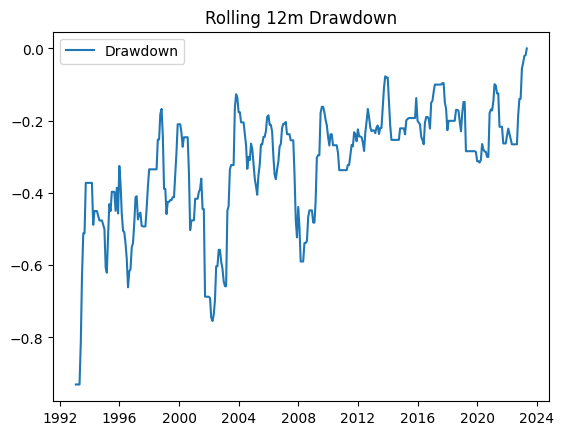

In [85]:
plt.plot(date_range, rolling_dd, label='Drawdown')
plt.title('Rolling 12m Drawdown')
plt.legend()
plt.show()

In [86]:
stats_portfolio_100 = pd.Series([portfolio_100_ann_mean * 100, portfolio_100_ann_std * 100, round(portfolio_100_sharpe, 2), portfolio_100_mdd * 100, portfolio_100_avg_pos * 100])

In [87]:
data_bounded_ger_inv['Portfolio_150_Ann'] = ((data_bounded_ger_inv['Portfolio_150'] + 1) ** 12) - 1

In [88]:
portfolio_150_ann_mean = np.mean(data_bounded_ger_inv['Portfolio_150_Ann'].tolist())
portfolio_150_ann_std = np.std(data_bounded_ger_inv['Portfolio_150_Ann'].tolist())
portfolio_150_sharpe = portfolio_150_ann_mean / portfolio_150_ann_std
portfolio_150_avg_pos = np.mean(data_bounded_ger_inv['Equity_Weight_150'].tolist())

In [89]:
rolling_dd = []
for index, value in enumerate(return_1m_pe150_cum_perc):
    rolling_max = max(return_1m_cum_perc[index:index + 12])
    rolling_min = min(return_1m_cum_perc[index:index + 12])
    rolling_dd.append((rolling_min - rolling_max) / rolling_max)

portfolio_150_mdd = min(rolling_dd)

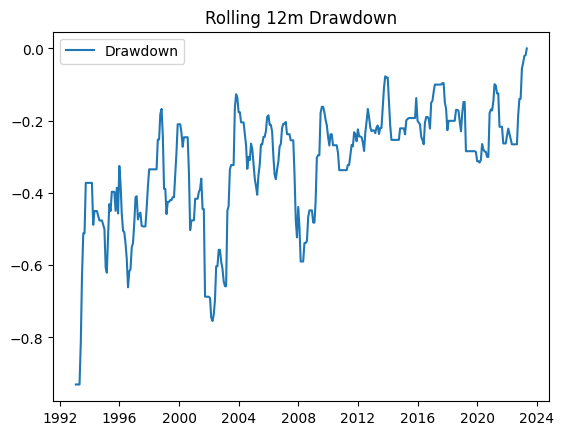

In [90]:
plt.plot(date_range, rolling_dd, label='Drawdown')
plt.title('Rolling 12m Drawdown')
plt.legend()
plt.show()

In [91]:
stats_portfolio_150 = pd.Series([portfolio_150_ann_mean * 100, portfolio_150_ann_std * 100, round(portfolio_150_sharpe, 2), portfolio_150_mdd * 100, portfolio_150_avg_pos * 100])

In [92]:
stats_portfolios = pd.concat([stats_portfolio_100,stats_portfolio_150], axis=1)
stats_portfolios.columns = ['Buy-and-hold','Value timing']
stats_portfolios['Stat'] = ['Return %', 'Volatility %', 'Sharpe ratio', 'Max 12m drawdown %', 'Average position %']
stats_portfolios = stats_portfolios.iloc[:,[2, 0, 1]]
stats_portfolios = stats_portfolios.round(2)
stats_portfolios

,Stat,Buy-and-hold,Value timing
0,Return %,35.52,47.00
1,Volatility %,102.47,135.35
2,Sharpe ratio,0.35,0.35
3,Max 12m drawdown %,-93.02,-93.02
4,Average position %,100.00,99.87


# Bibliography

http://www.econ.yale.edu/~shiller/data.htm

https://indices.cib.barclays/IM/21/en/indices/static/historic-cape.app

https://finance.yahoo.com/quote/%5EGDAXI/history/

https://www.macrotrends.net/2518/1-month-libor-rate-historical-chart

https://www.money.pl/pieniadze/depozyty/walutowearch/
